In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import glob
from PIL import Image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [3]:
positives = "/content/drive/MyDrive/Datasets/static_dataset/StaticA"
negatives = "/content/drive/MyDrive/Datasets/static_dataset/StaticN"

positives = np.array(glob.glob(positives + "/*.jpg"))
negatives = np.array(glob.glob(negatives + "/*.jpg"))

print("no of positive samples", len(positives))
print("no of negative samples", len(negatives))

train_images = []
train_labels = []
test_images = []
test_labels = []

training_positive, testing_positive = train_test_split(positives, test_size=0.2, random_state=42)
training_negative, testing_negative = train_test_split(negatives, test_size=0.2, random_state=42)

print("no of positive samples in training set", len(training_positive))
print("no of positive samples in testing set", len(testing_positive))
print("no of negative samples in training set", len(training_negative))
print("no of negative samples in testing set", len(testing_negative))


for i in training_positive:
  img = Image.open(i)
  train_images.append(np.array(img))
  train_labels.append(1)

for i in testing_positive:
  img = Image.open(i)
  test_images.append(np.array(img))
  test_labels.append(1)

for i in training_negative:
  img = Image.open(i)
  train_images.append(np.array(img))
  train_labels.append(0)

for i in testing_negative:
  img = Image.open(i)
  test_images.append(np.array(img))
  test_labels.append(0)

print(len(train_images), len(train_labels))
print(len(test_images), len(test_labels))




no of positive samples 124
no of negative samples 132
no of positive samples in training set 99
no of positive samples in testing set 25
no of negative samples in training set 105
no of negative samples in testing set 27
204 204
52 52


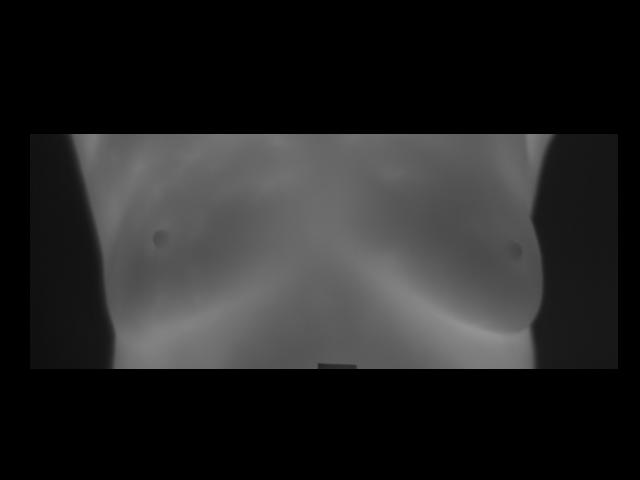

In [4]:
Image.open(positives[0])

In [5]:
print(train_images[0])
print(train_labels[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1


In [6]:
print(train_images[0].shape)

(480, 640)


In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        #returns total number of images
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.float)
        return image, label

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    #transforms.Resize((228, 228)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(degrees=15),  # Rotates images by up to 15 degrees
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0)), # Randomly crops and resizes images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])

])


train_dataset = CustomDataset(images=train_images, labels=train_labels, transform=transform)
test_dataset = CustomDataset(images=test_images, labels=test_labels, transform=transform)
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Data shape: torch.Size([1, 256, 256])
Labels shape: torch.Size([])


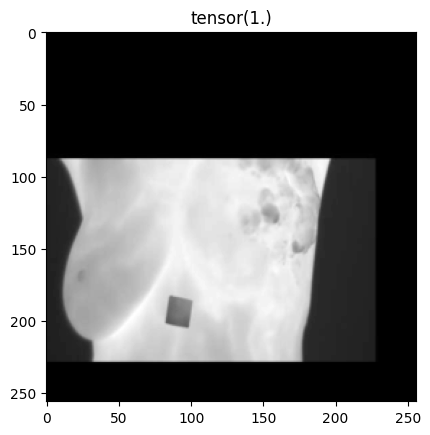

In [8]:
data, labels = train_dataset[0]
print("Data shape:", data.shape)
print("Labels shape:", labels.shape)
plt.imshow(data.squeeze(), cmap='gray')
plt.title(labels)
plt.show()


In [45]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()

    # Encoder
    self.enc1 = self.contracting_block(1, 64)
    self.enc2 = self.contracting_block(64, 128)
    self.enc3 = self.contracting_block(128, 256)
    self.enc4 = self.contracting_block(256, 512)

    # Bottleneck
    self.bottleneck = self.contracting_block(512, 1024)

    # Decoder
    self.dec4 = self.expansive_block(1024, 512)
    self.dec3 = self.expansive_block(512, 256)
    self.dec2 = self.expansive_block(256, 128)
    self.dec1 = self.expansive_block(128, 64)

    # Output
    self.output = nn.Sequential(
        nn.Conv2d(96, 1, kernel_size=1),
        nn.Sigmoid(),
        nn.Upsample(scale_factor=2)
    )

  def contracting_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

  def expansive_block(self, in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(out_channels, out_channels // 2, kernel_size=2, stride=2)
    )

  def forward(self, x):
    print(x.shape)
    enc1 = self.enc1(x)
    print(enc1.shape)
    enc2 = self.enc2(enc1)
    print(enc2.shape)
    enc3 = self.enc3(enc2)
    print(enc3.shape)
    enc4 = self.enc4(enc3)

    bottleneck = self.bottleneck(enc4)
    print(bottleneck.shape)

    dec4 = self.dec4(bottleneck)
    dec4 = torch.cat((dec4, enc4), dim=1)
    print(dec4.shape)
    self.dec3 = self.expansive_block(dec4.shape[1], 256)
    dec3 = self.dec3(dec4)
    dec3 = torch.cat((dec3, enc3), dim=1)
    print(dec3.shape)
    self.dec2 = self.expansive_block(dec3.shape[1], 128)
    dec2 = self.dec2(dec3)
    dec2 = torch.cat((dec2, enc2), dim=1)
    print(dec2.shape)
    self.dec1 = self.expansive_block(dec2.shape[1], 64)
    dec1 = self.dec1(dec2)
    dec1 = torch.cat((dec1, enc1), dim=1)
    print(dec1.shape)

    return torch.sigmoid(self.output(dec1))


In [46]:
model = UNet()
#print(model)

In [47]:
output = model(data.unsqueeze(0))
print(output.shape)

torch.Size([1, 1, 256, 256])
torch.Size([1, 64, 128, 128])
torch.Size([1, 128, 64, 64])
torch.Size([1, 256, 32, 32])
torch.Size([1, 1024, 8, 8])
torch.Size([1, 768, 16, 16])
torch.Size([1, 384, 32, 32])
torch.Size([1, 192, 64, 64])
torch.Size([1, 96, 128, 128])
torch.Size([1, 1, 256, 256])
